In [ ]:
%%capture
%run '/content/drive/MyDrive/Federated_Learning/CIFAR-10/IID/CIFAR10_Main.ipynb'

**Centralized Evaluation (or server-side evaluation)**: *It works the same way that evaluation in centralized machine learning does.*

**Federated Evaluation (or client-side evaluation)**: *It doesn’t require a centralized dataset and allows to evaluate models over a larger datasets The dataset held by each client can change over consecutive rounds. This can lead to evaluation results that are not stables.*

In [1]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480

In [2]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
# disable_progress_bar controls the visibility of progress bars
from torch.utils.data import DataLoader
import flwr
from flwr_datasets import FederatedDataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CLIENTS = 10
BATCH_SIZE = 32
# partition_id refers to client (0-9)
def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS}) #fds will contain the federated version of the CIFAR-10
    partition = fds.load_partition(partition_id)
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize(mean,std_dev)
        ]
    )

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]] #batch["img"] refers to list of images
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True # Retrieve training partition of the dataset from partition_train_test
    )
    valloader = DataLoader(
        partition_train_test["test"], batch_size=BATCH_SIZE
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(
        testset, batch_size=BATCH_SIZE
    )
    return trainloader, valloader, testloader

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.classifier=nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*4*4,512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512,10),
        )

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

In [3]:
from typing import Dict, Optional, Tuple
from flwr.common import NDArrays, Scalar

In [4]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [5]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [6]:
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

In [7]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    # config hold configurations related to training like number of epochs, learning rate, etc that control how the model is trained
    # or evaluated means hyperparameters
    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}
    # get_parameters(self.net) returns updated model parameters (weights and biases)
    # len(self.trainloader) returns number of training examples to perform weighted aggregation
    # {} optional metrics dictionary for loss, accuracy etc.

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [8]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    # node_config fetch data partition associated to that node
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    # FlowerClient is subclass of NumPyClient so we need to call .to_client() to convert it to subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [9]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [10]:
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar], # config is Flower standard function signature to dynamically pass extra info to the evaluation function
) -> Optional[Tuple[float, Dict[str, Scalar]]]: # float -> loss; str -> (accuracy/precision/recall); Scalar -> value of accuracy/precision/recall

    net = Net().to(DEVICE)
    _, _, testloader = load_datasets(0)
    set_parameters(net, parameters)
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}

In [11]:
test_accuracies = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [12]:
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [13]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [14]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [15]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=10,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1728) 2025-04-27 19:25:06.883523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1729) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1729) E0000 00:00:1745781906.893244    1729 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1728) E0000 00:00:1745781906.945331    1728 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=1729) /usr/local/lib/python3.11/dist-packages/jupyter_client/co

Round 1: Test Accuracy: 0.2200


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Accuracy: 0.3990


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Accuracy: 0.4474


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Accuracy: 0.5034


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Test Accuracy: 0.5276


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Accuracy: 0.5478


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Accuracy: 0.5832


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.5954


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Accuracy: 0.6034


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 3221.62s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07273617067337036
INFO :      		round 2: 0.05466434972286225
INFO :      		round 3: 0.04834256610870361
INFO :      		round 4: 0.04424742743968964
INFO :      		round 5: 0.04210557788610458
INFO :      		round 6: 0.03971715006828308
INFO :      		round 7: 0.03779695209264755
INFO :      		round 8: 0.03653255136013031
INFO :      		round 9: 0.03562354781627655
INFO :      		round 10: 0.03367523744106293
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.22000000000000003),
INFO :      	              (2, 0.399),
INFO :      	              (3, 0.4474),
INFO :      	              (4, 0.5034000000000001),
INFO 

Round 10: Test Accuracy: 0.6280


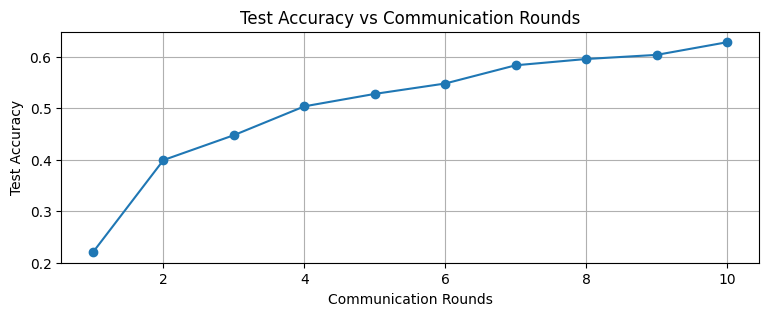

In [16]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

Sending/receiving arbitrary values to/from clients

Now, we’ll tell at runtime from the server how many epochs (or other parameters) to use."

We're enabling dynamic control from the server side to make it flexible.

Ex. -> In Round 1, train for 1 epoch; In Round 2, train for 2 epochs; Later rounds, increase epochs dynamically or change learning rate mid-training.

In [17]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader):
        self.pid = pid  # Partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config): # config is a dictionary to store hyperparamaters
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        server_round = config["server_round"] # current round of training in the federated learning process
        local_epochs = config["local_epochs"] # number of local epochs each client should train its data before sending updates back to server
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [18]:
def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id)
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [19]:
def fit_config(server_round: int):
    # Return training configuration dict for each round.
    config = {
        "server_round": server_round,
        "local_epochs": 1 if server_round < 2 else 2,
    }
    return config

In [20]:
test_accuracies = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [22]:
from flwr.common import ndarrays_to_parameters
params = get_parameters(Net())

In [21]:
def evaluate(server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = Net().to(DEVICE)
    _, _, testloader = load_datasets(0)
    set_parameters(net, parameters)
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}

In [23]:
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_fn=evaluate,
    initial_parameters=ndarrays_to_parameters(params),
    on_fit_config_fn=fit_config,
)

In [24]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=10,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
(pid=16298) 2025-04-27 20:19:30.359207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=16298) WARNING: Al

Server-side evaluation loss 0.07207258071899414 / accuracy 0.0979


(ClientAppActor pid=16297) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=16297) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=16297) see the appropriate new directories, set the environment variable
(ClientAppActor pid=16297) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=16297) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=16297)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
(pid=16297) 2025-04-27 20:19:30.567292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=16297) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=16297) E0000 00:00:174578

(ClientAppActor pid=16298) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=16298) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=16298) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=16298) [Client 9, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=16298) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 0.07094171071052552, {'accuracy': 0.1885}, 331.5342986659998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation loss 0.07094171071052552 / accuracy 0.1885
(ClientAppActor pid=16298) [Client 2] evaluate, config: {}
(ClientAppActor pid=16297) [Client 1, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=16298) [Client 6] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=16298) [Client 9] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Accuracy: 0.0000
(ClientAppActor pid=16297) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(ClientAppActor pid=16297) [Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 8, round 2] fit, config: {'server_round': 2, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16298) [Client 9, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(ClientAppActor pid=16297) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(ClientAppActor pid=16297) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16298) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (2, 0.04993879064321518, {'accuracy': 0.4452}, 972.2019565789997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation loss 0.04993879064321518 / accuracy 0.4452
(ClientAppActor pid=16297) [Client 2] evaluate, config: {}
(ClientAppActor pid=16297) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 7] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Accuracy: 0.0000
(ClientAppActor pid=16297) [Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(ClientAppActor pid=16297) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 8, round 3] fit, config: {'server_round': 3, 'local_epochs': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (3, 0.040492119020223614, {'accuracy': 0.5337}, 1603.9536048419995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation loss 0.040492119020223614 / accuracy 0.5337
(ClientAppActor pid=16297) [Client 5] evaluate, config: {}
(ClientAppActor pid=16298) [Client 7, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(ClientAppActor pid=16297) [Client 6] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 9] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Accuracy: 0.0000
(ClientAppActor pid=16297) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(ClientAppActor pid=16297) [Client 6, round 4] fit, config: {'server_round': 4, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 8, round 4] fit, config: {'server_round': 4, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (4, 0.03667259564995766, {'accuracy': 0.5883}, 2235.7416354429997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation loss 0.03667259564995766 / accuracy 0.5883
(ClientAppActor pid=16297) [Client 1] evaluate, config: {}
(ClientAppActor pid=16298) [Client 2, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(ClientAppActor pid=16297) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 8] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Accuracy: 0.0000
(ClientAppActor pid=16298) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(ClientAppActor pid=16298) [Client 5, round 5] fit, config: {'server_round': 5, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 7, round 5] fit, config: {'server_round': 5, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (5, 0.03393048633337021, {'accuracy': 0.6213}, 2865.2528186199997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation loss 0.03393048633337021 / accuracy 0.6213
(ClientAppActor pid=16297) [Client 3] evaluate, config: {}
(ClientAppActor pid=16298) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(ClientAppActor pid=16297) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 7] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Test Accuracy: 0.0000
(ClientAppActor pid=16298) [Client 2, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(ClientAppActor pid=16297) [Client 3, round 6] fit, config: {'server_round': 6, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 6, round 6] fit, config: {'server_round': 6, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 7, round 6] fit, config: {'server_round': 6, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16298) [Client 4, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (6, 0.03144475353956223, {'accuracy': 0.6503}, 3490.2764420129997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation loss 0.03144475353956223 / accuracy 0.6503
(ClientAppActor pid=16297) [Client 3] evaluate, config: {}
(ClientAppActor pid=16297) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 8] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Accuracy: 0.0000
(ClientAppActor pid=16298) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(ClientAppActor pid=16297) [Client 3, round 7] fit, config: {'server_round': 7, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 8, round 7] fit, config: {'server_round': 7, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 6, round 7] fit, config: {'server_round': 7, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 0, round 7] fit, config: {'server_round': 7, 'local_epochs': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (7, 0.029638933092355726, {'accuracy': 0.6698}, 4110.655696051)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation loss 0.029638933092355726 / accuracy 0.6698
(ClientAppActor pid=16297) [Client 2] evaluate, config: {}
(ClientAppActor pid=16298) [Client 4, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(ClientAppActor pid=16297) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 6] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Accuracy: 0.0000
(ClientAppActor pid=16298) [Client 4, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(ClientAppActor pid=16297) [Client 6, round 8] fit, config: {'server_round': 8, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 8, round 8] fit, config: {'server_round': 8, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16298) [Client 1, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (8, 0.028063536751270293, {'accuracy': 0.6887}, 4732.593437275001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation loss 0.028063536751270293 / accuracy 0.6887
(ClientAppActor pid=16298) [Client 1] evaluate, config: {}
(ClientAppActor pid=16298) [Client 6] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=16298) [Client 8] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.0000
(ClientAppActor pid=16298) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(ClientAppActor pid=16298) [Client 6, round 9] fit, config: {'server_round': 9, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16298) [Client 8, round 9] fit, config: {'server_round': 9, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 2, round 9] fit, config: {'server_round': 9, 'local_epochs': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (9, 0.026783922028541567, {'accuracy': 0.7044}, 5362.112660440999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation loss 0.026783922028541567 / accuracy 0.7044
(ClientAppActor pid=16298) [Client 3] evaluate, config: {}
(ClientAppActor pid=16298) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(ClientAppActor pid=16298) [Client 6] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=16298) [Client 9] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Accuracy: 0.0000
(ClientAppActor pid=16298) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(ClientAppActor pid=16298) [Client 2, round 10] fit, config: {'server_round': 10, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 7, round 10] fit, config: {'server_round': 10, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 3, round 10] fit, config: {'server_round': 10, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 5, round 10] fit, config: {'server_round': 10, 'local_epochs': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (10, 0.025699406030774117, {'accuracy': 0.7175}, 6008.449051989)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation loss 0.025699406030774117 / accuracy 0.7175
(ClientAppActor pid=16297) [Client 2] evaluate, config: {}
(ClientAppActor pid=16298) [Client 8, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(ClientAppActor pid=16297) [Client 6] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=16297) [Client 9] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 6026.06s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07253123688697816
INFO :      		round 2: 0.05145063595771789
INFO :      		round 3: 0.041909519553184504
INFO :      		round 4: 0.03762827554941177
INFO :      		round 5: 0.03441960637569427
INFO :      		round 6: 0.03213888101577759
INFO :      		round 7: 0.030052441632747652
INFO :      		round 8: 0.028912511098384858
INFO :      		round 9: 0.027645440858602523
INFO :      		round 10: 0.025913463550806044
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07207258071899414
INFO :      		round 1: 0.07094171071052552
INFO :      		round 2: 0.04993879064321518
INFO :      		round 3: 0.040492119020223614
INFO :      		round 4: 0.03667259564995766
INFO :      		round 5: 0.03393048633337021
INFO :      		round 6: 0.03144475353956223
INFO :      		round 7: 0.029

Round 10: Test Accuracy: 0.0000


(ClientAppActor pid=16298) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=16298) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=16298) see the appropriate new directories, set the environment variable
(ClientAppActor pid=16298) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=16298) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=16298)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


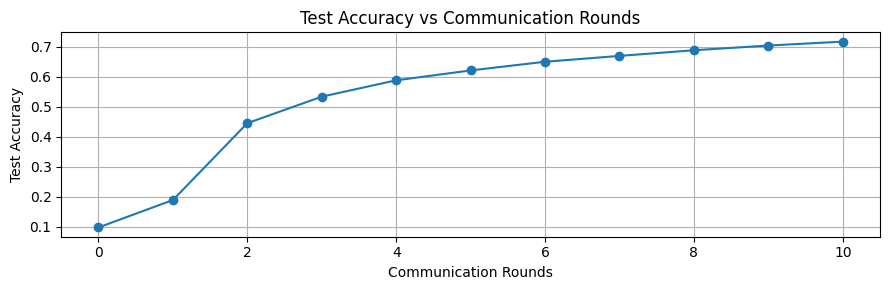

In [26]:
rounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracies = [0.0970, 0.1885, 0.4452, 0.5337, 0.5883, 0.6213, 0.6503, 0.6698, 0.6887, 0.7044, 0.7175]

plt.figure(figsize=(9, 3))
plt.plot(rounds, accuracies,marker='o',linestyle='-')
plt.title('Test Accuracy vs Communication Rounds')
plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()